In [135]:
import pandas as pd
import sqlite3
import numpy as np
import json

def load_data_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM {tbl} WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

In [136]:
#calculate centrality
import math
import numpy as np

def entropynorm(values):
    vs = np.array(values)
    num = vs.size
    tt = np.sum(vs)
    vs = vs/tt

    npi = np.sum(vs*np.log2(vs, out=np.zeros_like(vs), where=(vs!=0)))
    dpi = math.log2(num)
    return - npi/dpi

def fairnessnorm(values):
    vs = np.array(values)
    num = vs.size

    npi = np.sum(vs)
    npi = npi**2
    dpi = np.square(vs).sum()
    dpi = dpi*num
    
    fn = (npi/dpi - 1/num) / (1 - 1/num)
    
    return fn

values_list = [
                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                [0.17, 0.17, 0.13, 0.12, 0.11, 0.09, 0.07, 0.06, 0.05, 0.03],
                [0.42, 0.2, 0.14, 0.07, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01]
                ]

print(entropynorm(values_list[2]))
print(fairnessnorm(values_list[1]))

0.7556018366014379
0.8056472313898059


In [137]:
import os

# PATH = "../blockchainnode/db_nodes"
# PATH = "/Users/jwheo/Projects/bcsos/PoS_20221130_083413"
PATH = "/Users/jwheo/Projects/bcsos/PPOS_EXT_64_btc_20231004_080506"

fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[-1] == 'db']
if len(fdbs) == 0:
    subdirs = [x[0] for x in os.walk(PATH)]
    for subd in subdirs:
        subbs = [os.path.join(subd, f) for f in os.listdir(subd) if f.split(".")[-1] == 'db']
        fdbs.extend(subbs)

fdbs.sort()
print(fdbs)

['/Users/jwheo/Projects/bcsos/PPOS_EXT_64_btc_20231004_080506/node0.local/7031.db', '/Users/jwheo/Projects/bcsos/PPOS_EXT_64_btc_20231004_080506/node1.local/7032.db', '/Users/jwheo/Projects/bcsos/PPOS_EXT_64_btc_20231004_080506/node2.local/7033.db', '/Users/jwheo/Projects/bcsos/PPOS_EXT_64_btc_20231004_080506/node3.local/7034.db', '/Users/jwheo/Projects/bcsos/PPOS_EXT_64_btc_20231004_080506/node4.local/7035.db', '/Users/jwheo/Projects/bcsos/PPOS_EXT_64_btc_20231004_080506/node5.local/7036.db', '/Users/jwheo/Projects/bcsos/PPOS_EXT_64_btc_20231004_080506/node6.local/7037.db', '/Users/jwheo/Projects/bcsos/PPOS_EXT_64_btc_20231004_080506/node7.local/7038.db']


[46, 43, 45, 38, 46, 45, 53, 45] 361
[47, 37, 49, 33, 46, 43, 51, 52] 358
Fairness Proof 0.9917205714633955
Fairness Verification 0.9777906021020233
Entropy Proof 0.9982505842009433
Entropy Verification 0.9950419154453573


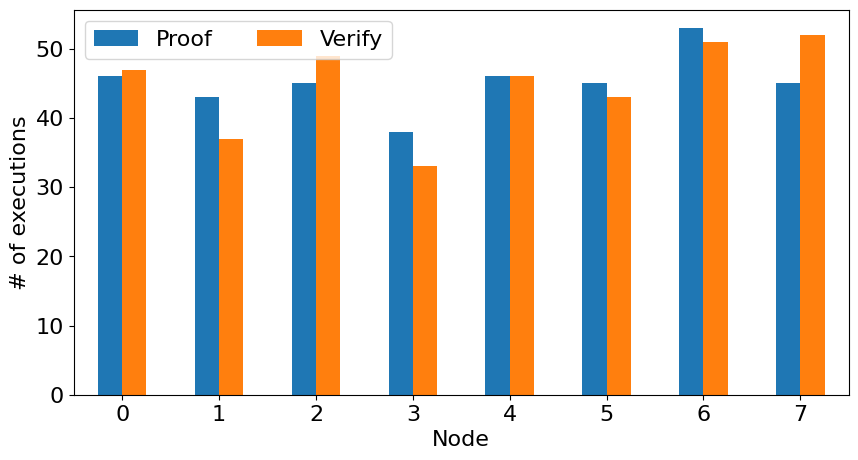

In [138]:
# Count chart for proof and verify
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 16})
    
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df.shape[0])
print(proof, sum(proof))

dfs = load_data_from_db(fdbs, 'veriftbl')
verif = []
for i, df in enumerate(dfs):
    verif.append(df.shape[0])
print(verif, sum(verif))

ch_list = [proof, verif]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("# of executions")
plt.legend(ncol=2)
plt.savefig('Num_Prover_Verifier_btc_64.png', dpi=300, bbox_inches='tight')

print('Fairness Proof', fairnessnorm(proof))
print('Fairness Verification', fairnessnorm(verif))

print('Entropy Proof', entropynorm(proof))
print('Entropy Verification', entropynorm(verif))




Proofs[ms] [14.182672630434784, 8.631365906976745, 13.247365733333332, 13.052756631578946, 9.724960391304348, 13.3765964, 13.226690094339622, 29.448837088888887]
Verif Fwds[ms] [31753.32604680851, 34016.29164245946, 36487.790331020406, 38712.07487151515, 32626.89788682609, 36285.38265762791, 34883.325231, 35795.30998275]
Verif Backs[ms] [833.1411370425532, 858.6989027297298, 904.3403188775511, 953.9911386060606, 810.3746932608697, 836.0616206976744, 786.8285212549021, 848.8409957307692]
Avg Proof[ms] 14.361405609607083
Avg Verif Fwd[ms] 35070.049831250944
Avg Verif Back[ms] 854.0346660250138


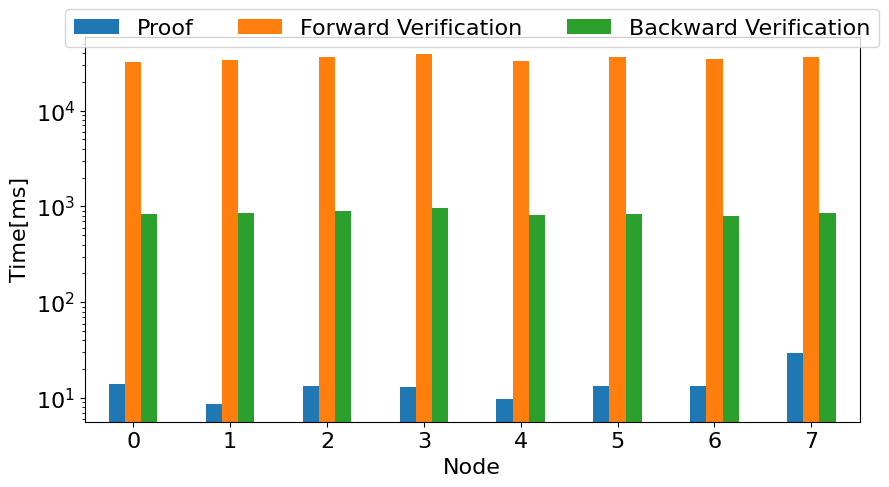

In [139]:
# Avg. Time chart for proof and verify
from matplotlib import pyplot as plt

df_csv = pd.DataFrame()

unit = 1000000 #msec
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['timegenproof'].mean()/unit)
# print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
veriffwd = []
verifrev = []
for i, df in enumerate(dfs):
    # print(df.columns)
    veriffwd.append(df['timeveriffwd'].mean()/unit)
    verifrev.append(df['timeverifrev'].mean()/unit)
# print(veriffwd)
# print(verifrev)

ch_list = [proof, veriffwd, verifrev]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Forward Verification', 'Backward Verification']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("Time[ms]")
# plt.legend(loc='right')
ax.set_yscale('log')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=5)

plt.savefig('Avg_Time_Proof_Verify.png', dpi=300, bbox_inches='tight')

print('Proofs[ms]', proof)
print('Verif Fwds[ms]', veriffwd)
print('Verif Backs[ms]', verifrev)

df_csv['Proof Time'] = proof
df_csv['Forward Verification Time'] = veriffwd
df_csv['Backward Verification Time'] = verifrev

print('Avg Proof[ms]', sum(proof)/len(proof))
print('Avg Verif Fwd[ms]', sum(veriffwd)/len(veriffwd))
print('Avg Verif Back[ms]', sum(verifrev)/len(verifrev))


[14.182672630434784, 8.631365906976745, 13.247365733333332, 13.052756631578946, 9.724960391304348, 13.3765964, 13.226690094339622, 29.448837088888887]
forward proof size [948.0231304347826, 843.9162790697675, 990.9535999999999, 883.9063157894738, 1110.4819130434782, 955.9859555555555, 985.2796981132076, 978.0264888888888]
backward proof size [2105.956695652174, 1743.7477209302326, 2020.3032888888888, 1892.9974736842105, 2220.140347826087, 1858.143111111111, 1677.3363018867926, 1925.2211555555557]
Avg size of forward proof 962.0716726118943
Avg size of backward proof 1930.4807619418814


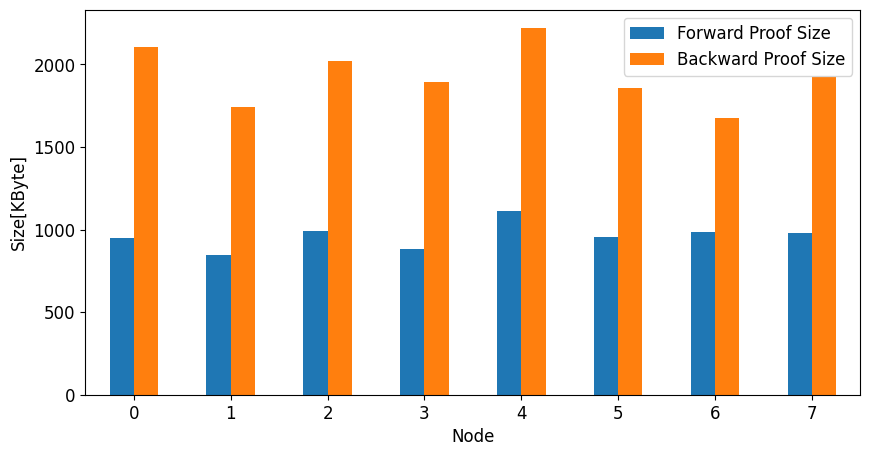

In [140]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size': 12})

unit = 1000 #kbyte
dfs = load_data_from_db(fdbs, 'prooftbl')
prooffwd = []
proofbck = []
for i, df in enumerate(dfs):
    prooffwd.append(df['sizefwdproof'].mean()/unit)
    proofbck.append(df['sizebckproof'].mean()/unit)
print(proof)

ch_list = [prooffwd, proofbck]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Forward Proof Size', 'Backward Proof Size']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("Size[KByte]")
plt.savefig('Avg_Size_Proof.png', dpi=300, bbox_inches='tight')

print('forward proof size', prooffwd)
print('backward proof size', proofbck)

df_csv['Forward Proof Size'] = prooffwd
df_csv['Backward Proof Size'] = proofbck

print('Avg size of forward proof', sum(prooffwd)/len(prooffwd))
print('Avg size of backward proof', sum(proofbck)/len(proofbck))


In [141]:
df_csv.to_csv(PATH+'.csv')

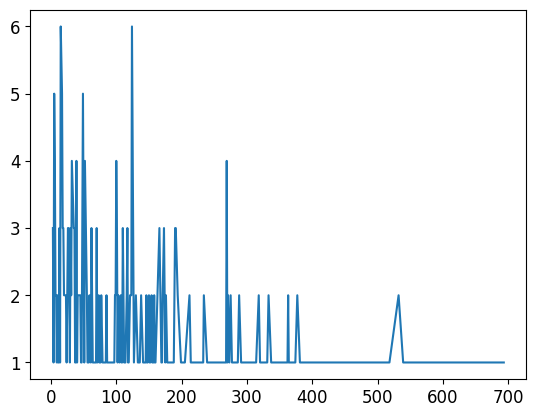

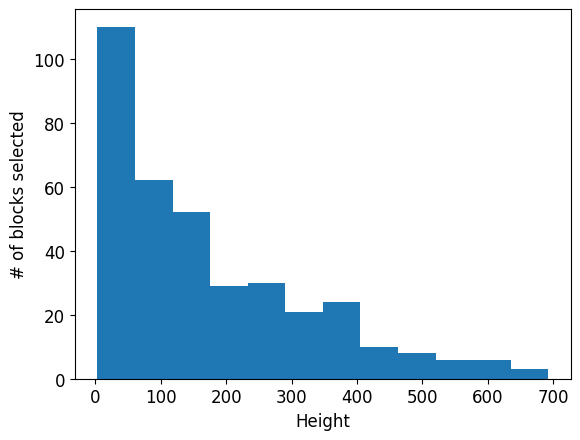

In [142]:
# List up proof block and show it in the time order 
from matplotlib import pyplot as plt

dfs = load_data_from_db(fdbs, 'prooftbl')
hash = []
for i, df in enumerate(dfs):
    for s in df['proofblock']:        
        hash.append(s)
# print(hash)

height = []
for i, df in enumerate(dfs):
    for h in df['proofheight']:        
        height.append(h)
# print(height)

ch_list = [hash, height]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Hash', 'Height']

bdf = bdf.sort_values(by=['Height'])
bdf2 = bdf.groupby(['Height'])['Height'].count().reset_index(name="Count")

plt.plot(bdf2['Height'], bdf2['Count'])

bdf = pd.DataFrame([height]).transpose()
ax = bdf.plot.hist(bins=12, label='Count')
ax.get_legend().remove()

plt.xlabel("Height")
plt.ylabel("# of blocks selected")

plt.savefig('Proof_Blocks.png', dpi=300, bbox_inches='tight')



0.5394239564467025 0.9577763666665545
0.6486151743984518 0.9518427248856928
0.3113095022258949 0.9160794378376254


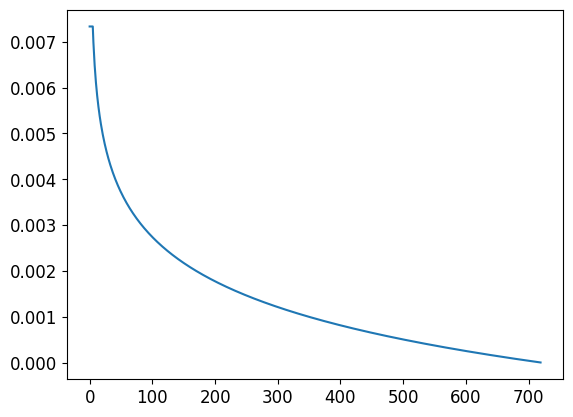

In [143]:
import numpy as np
 
def cal_evenness1(vdf, vmax):
    vdf['weight'] = (vmax - vdf['Height'])
    vdf['norm_cnt1'] = vdf['Count']/vdf['weight']
    values = vdf['norm_cnt1'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    
def cal_evenness2(vdf, vmax):
    vdf['norm_cnt2'] = vdf['Count']*vdf['Height']
    values = vdf['norm_cnt2'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)

def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(max(i, 5), vmax):
            pi += 1/(j-1)
        # pi = pi*np.log10(pi)
        pis.append(pi)
    
    # mpis = max(pis)
    mpis = sum(pis)
    # https://en.wikipedia.org/wiki/Entropy_(information_theory)
    pis2 = [x /mpis for x in pis]
    pis3 = [-np.log2(x) for x in pis2] 
    # print(pis2)
    plt.plot(pis2)
    return pis2, pis3

def cal_evenness3(vdf, vmax):
    # vdf = sdf.copy()
    pis, pis2 = cal_acc_prob(vmax)

    # vdf.set_index('Height', inplace=True)
    # vdf = vdf.reindex(list(range(0,vmax)),fill_value=0)    
    # vdf['weight'] =  pis
    # vdf['weight3'] = [pis2[v] for v in vdf['Height'].values]
    vdf['weight3'] = [1/pis[v] for v in vdf['Height'].values]
    # print('weights',vdf)
    vdf['norm_cnt3'] = vdf['Count']*vdf['weight3']
    # vdf['norm_cnt'] = vdf['Count2']*vdf['weight']

    # plt.plot(vdf['weight3'])

    # values = vdf['Count'].to_list()
    # vs = np.array(values)
    # num = vs.size
    # tt = np.sum(vs)
    # vs = vs/tt
    # # print('p(x)', vs)

    # ci_values =  vdf['weight3'].to_list()
    # ci = np.array(ci_values)
    # # print('CI=====', ci)

    # se = vs*ci
    # npi = np.sum(vs*ci)
    # dpi = math.log2(num)
    # print('Entropy', npi/dpi)
    # plt.plot(vs, 'g')
    # # plt.plot(ci, 'r')
    # plt.plot(se, 'b')

    values = vdf['norm_cnt3'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    # print(values)
    # plt.plot(values)
    
    # print(vdf['norm_cnt'])
    
    # vdf['norm_cnt'].plot()
cal_evenness1(bdf2, 720)
cal_evenness2(bdf2, 720)
cal_evenness3(bdf2, 720)

# print(bdf2)
# plt.plot(bdf2['norm_cnt1']*50, 'r')
# plt.plot(bdf2['norm_cnt2']/1284, 'b')
# plt.plot(bdf2['norm_cnt3']/20, 'g')



In [144]:
def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(i, vmax):
            pi += 1/(j+1)
        pis.append(pi*np.log10(i+1))
    # print(pis)
    
    return pis
pis = cal_acc_prob(720)
# plt.plot(pis)
bdf = pd.DataFrame([pis]).transpose()
bdf.columns = ['Count']
# ax = bdf.plot.hist(bins=12, label='Count')
bdf2

,Height,Count,weight,norm_cnt1,norm_cnt2,weight3,norm_cnt3
0,3,3,717,0.004184,9,136.372023,409.116069
1,4,1,716,0.001397,4,136.372023,136.372023
2,5,5,715,0.006993,25,136.372023,681.860115
3,6,4,714,0.005602,24,143.095092,572.380367
4,7,2,713,0.002805,14,148.970423,297.940845
...,...,...,...,...,...,...,...
236,613,1,107,0.009346,613,4500.085939,4500.085939
237,614,1,106,0.009434,614,4546.153049,4546.153049
238,636,1,84,0.011905,636,5836.495298,5836.495298
239,676,1,44,0.022727,676,11482.765422,11482.765422


======== 64
======== 32
======== 40
======== 56
======== 48
       Encoding    Decoding          Size  GF
0  10054.007812  484.276215  1.023033e+06  32
0  12521.073437  466.666840  1.023033e+06  40
0  14369.423438  435.089583  1.023034e+06  48
0  16733.086111  425.523264  1.023034e+06  56
0  20544.534028  448.215104  1.023035e+06  64


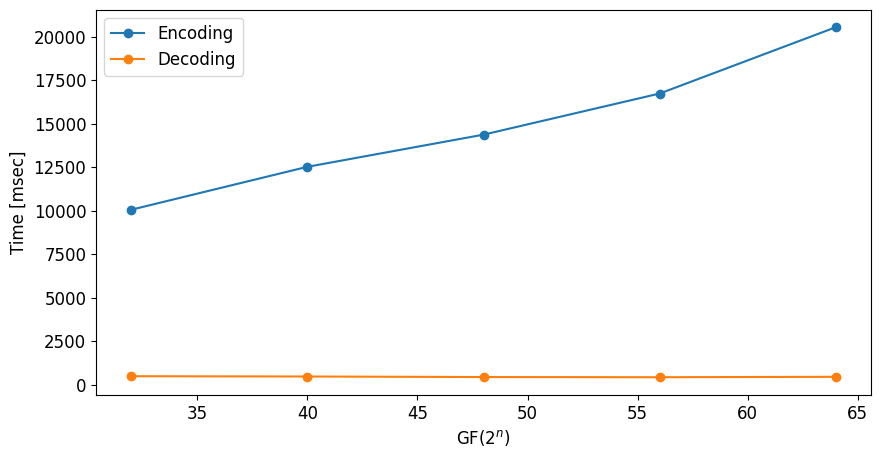

In [145]:
import os
import pandas as pd
from matplotlib import pyplot as plt

PATH = "../PPoS_ext_btc"

fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[0].find('PPOS_EXT_') == 0]
dbs = {}
for i, f in enumerate(fdbs):
    key = f.split('_')[6]
    print("========", key)
    tdbs = []    
    subdirs = [x[0] for x in os.walk(f)]
    for subd in subdirs:
        subbs = [os.path.join(subd, f) for f in os.listdir(subd) if f.split(".")[-1] == 'csv']
        if len(subbs) > 0 and subbs[0].find('.csv') != -1:
            tdbs.append(subbs[0])            
    dbs[key] = tdbs
gfs = list(dbs.keys())
gfs.sort()

dfcs = pd.DataFrame()
for g in gfs:
    ss = dbs[g]
    dfg = pd.DataFrame()
    for s in ss:        
        df = pd.read_csv(s, header=None)
        df.rename(columns = {0:'Encoding', 1:'Decoding', 2:"Size"}, inplace = True)
        m = df.mean()
        dfg = pd.concat([dfg, pd.DataFrame(m).transpose()], axis=0)
    dfc = pd.DataFrame(dfg.mean()).transpose()
    dfc["GF"] = int(g)
    dfcs = pd.concat([dfcs, dfc], axis=0)
print(dfcs)

plt.figure(figsize=(10,5))
plt.plot( dfcs['GF'], dfcs['Encoding'], marker='o', label="Encoding")
plt.plot( dfcs['GF'], dfcs['Decoding'], marker='o', label="Decoding")
plt.legend(loc="upper left")
plt.ylabel("Time [msec]")
plt.xlabel("GF($2^n$)")
plt.show()
# print(fdbs)

======== 64
======== 32
======== 40
======== 56
======== 48


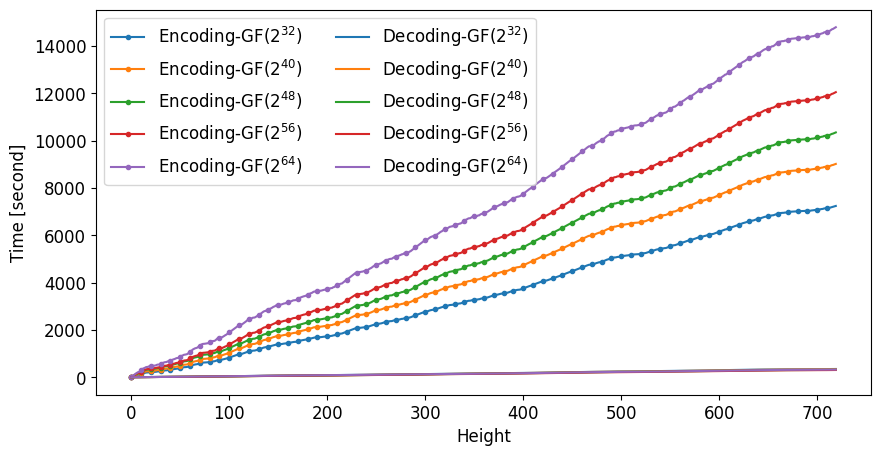

In [146]:
import os
import pandas as pd
from matplotlib import pyplot as plt

PATH = "../PPoS_ext_btc"

plt.rcParams.update({'font.size': 12})

fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[0].find('PPOS_EXT_') == 0]
dbs = {}
for i, f in enumerate(fdbs):
    key = f.split('_')[6]
    print("========", key)
    tdbs = []    
    subdirs = [x[0] for x in os.walk(f)]
    for subd in subdirs:
        subbs = [os.path.join(subd, f) for f in os.listdir(subd) if f.split(".")[-1] == 'csv']
        if len(subbs) > 0 and subbs[0].find('.csv') != -1:
            tdbs.append(subbs[0])            
    dbs[key] = tdbs
gfs = list(dbs.keys())
gfs.sort()

panels = {}
for g in gfs:
    ss = dbs[g]
    dfs = []
    for s in ss:        
        df = pd.read_csv(s, header=None)
        df.rename(columns = {0:'Encoding', 1:'Decoding', 2:"Size"}, inplace = True)        
        dfs.append(df)
    
    panel = pd.concat(dfs).groupby(level=0).mean()
    panels[g] = panel

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.figure(figsize=(10,5))
for i, (g, df) in enumerate(panels.items()):
    plt.plot(df.index.values, df['Encoding'].cumsum()/1000, marker='.', markevery=10, color=colors[i], label="Encoding-GF($2^{{{}}}$)".format(g))
for i, (g, df) in enumerate(panels.items()):
    plt.plot(df.index.values, df['Decoding'].cumsum()/1000, color=colors[i], label="Decoding-GF($2^{{{}}}$)".format(g))
plt.legend(loc="upper left")
plt.legend(ncol=2)
plt.ylabel("Time [second]")
plt.xlabel("Height")
plt.savefig('fg_acc_encryption_btc.png',  dpi=300, bbox_inches='tight')
# plt.show()
